In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/char_transformer

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZdikWibndOy-EAHWOwKrJSalwWRmsckp/char_transformer


In [2]:
# Enable autoreload of local Python modules (e.g., models)
#%load_ext autoreload
#%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import numpy as np
import optax
import time
from functools import partial
import matplotlib.pyplot as plt

# local imports
import models.swiglu as models
import util.generation as generation


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

t of the population in chinese traditional culture being overweight was a sign of prosperity and wealth as only the wealthy coul

ne eight even bell labs uses the term laser history in one nine one six albert einstein laid the foundation for the invention of

 tammany the houma in east and west feliciana and pointe coupee parishes about one zero zero miles north of the town named for t

she published seven volumes of short stories and poetry enough rope sunset gun laments for the living death and taxes after such

will appear in this case the solid angle of interest is the solid angle subtended by the eye s pupil luminance is used in the vi



# Create a basic Transformer model

In [9]:
import jax.random as random
import jax


In [10]:
def create_train_state(rng=jax.random.key(0), vocab_size=27,
    d_model=256, n_layers=3, n_heads=8, max_len=128):
    # create a basic Transformer model
    base_model = models.DecoderOnlyTransformer(
      vocab_size=vocab_size,
      d_model=d_model,
      n_layers=n_layers,
      n_heads=n_heads,
      max_len=max_len,
      mlp_ratio=8/3,
      dropout_rate=0.00,
      tie_weights=True,
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = base_model.init({"params": rng, "dropout": rng}, dummy, deterministic=True)["params"]
    return base_model, params

In [11]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [12]:
model_1, params_1 = create_train_state()

print(f"base model param_count: {count_params(params_1):_}")

base model param_count: 2_405_884


In [13]:
# sanity check: create a batch of data & run a forward pass
'''
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)
'''

'\nB, T = 4, 32\nbatch = jax.random.randint(\n    key=key,\n    shape=(B, T), minval=0, maxval=len(char_set))\nlogits = model.apply({"params": params}, batch)\n\nprint("batch shape:", batch.shape)  # (B, T)\nprint("logits shape:", logits.shape)  # (B, T, vocab_size)\n'

# Loss function

In [14]:
# --- Loss and metrics (JIT-friendly) ---
import jax.nn as jnn
from functools import partial

@jax.jit
def loss_and_metrics(logits, targets):
    vocab_size = logits.shape[-1]
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = targets.reshape(-1)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits_flat, targets_flat).mean()

    # compute token-level accuracy
    preds = jnp.argmax(logits, axis=-1)
    acc = (preds == targets).mean()

    # ✅ compute last character accuracy (final token per sequence) // NEW
    last_token_acc = (preds[:, -1] == targets[:, -1]).mean()

     # ✅ include it in the returned metrics
    return loss, {
        "loss": loss,
        "acc": acc,
        "acc_last": last_token_acc, # // NEW
    }

# Optimization step:

In [15]:
# create an update function
def train_step(params, opt_state, x, y, rng, tx, model):
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=False)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))


# Batch creation:

In [16]:
import jax
import jax.numpy as jnp

def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [17]:
# --- Optimizer and learning rate schedule ---
import optax

tx1 = lambda peak_lr, end_lr: optax.chain(
    optax.clip_by_global_norm(1.0),            # gradient clipping
    optax.adamw(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=peak_lr,
            warmup_steps=5000,
            decay_steps=max(1, 500_000 - 5000),
            end_value=end_lr,
      ), weight_decay=0.01)
  )

In [21]:
def train(tx, B=256, T=32, niter=500_000, tl=5*60):
    model, params = create_train_state()
    print(f"No. of parameters: {count_params(params):_}")
    opt_state = tx.init(params)
    # produce a fresh subkey for randomness (dropout)
    rng, dropout_rng = jax.random.split(jax.random.key(0))
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    last_acc_test_history = []
    time_start = time.time()
    it = 0
    while it < niter and time.time() - time_start < tl:
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(
            params, opt_state, input, target, rng,
            tx=tx, model=model)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 500) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, T
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            last_acc_test_history.append(test_acc_last)
        if it % (niter // 100) == 0 or it == niter - 1:
            print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
            print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
            print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
            print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
            print()
        it += 1
    print(it)
    return loss_history, time_history, loss_test_history, time_test_history, last_acc_test_history, params



In [19]:
import csv

def csv_writing(lh, th, lth, tth, lath, suffix):
    # Training metrics
    train_file_name = f"./data/train_loss_{suffix}_final.csv"
    with open(train_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "loss"])  # header
        writer.writerows(zip(th, lh))

    test_file_name = f"./data/test_loss_{suffix}_final.csv"
    # Test metrics
    with open(test_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "loss", "last acc"])  # header
        writer.writerows(zip(tth, lth, lath))

    print("csv files saved:", train_file_name, test_file_name)

In [22]:
peak, end = 1e-3, 1e-5
lh1, th1, lth1, tth1, lath1, params_1 = train(tx1(peak, end), tl=float('inf'))
csv_writing(lh1, th1, lth1, tth1, lath1, f"(Base + SwiGLU + WT + LPE + LR_cos_decay)")

No. of parameters: 2_405_884
iteration 0  time: 10.0 seconds
	 	 loss(train :: test): 3.7879 :: 3.7898
	 	 accuracy (train :: test): 2.8% :: 2.6%
	 	 accuracy (last character) (train :: test): 2.7% :: 2.6%

iteration 5_000  time: 29.5 seconds
	 	 loss(train :: test): 1.3879 :: 1.3862
	 	 accuracy (train :: test): 56.3% :: 56.8%
	 	 accuracy (last character) (train :: test): 64.5% :: 60.8%

iteration 10_000  time: 49.1 seconds
	 	 loss(train :: test): 1.2880 :: 1.3457
	 	 accuracy (train :: test): 59.8% :: 57.9%
	 	 accuracy (last character) (train :: test): 66.0% :: 62.3%

iteration 15_000  time: 68.7 seconds
	 	 loss(train :: test): 1.2783 :: 1.3102
	 	 accuracy (train :: test): 59.8% :: 58.9%
	 	 accuracy (last character) (train :: test): 68.8% :: 64.3%

iteration 20_000  time: 88.2 seconds
	 	 loss(train :: test): 1.2641 :: 1.3074
	 	 accuracy (train :: test): 59.9% :: 58.9%
	 	 accuracy (last character) (train :: test): 60.5% :: 64.0%

iteration 25_000  time: 107.7 seconds
	 	 loss

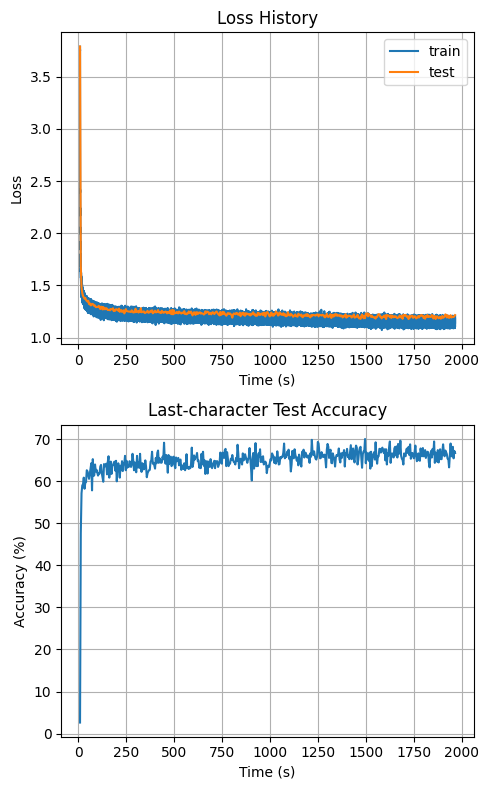

In [42]:
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
plt.plot(th1, lh1, label="train")
plt.plot(tth1, lth1, label="test")
plt.title("Loss History")
plt.xlabel("Time (s)")
plt.ylabel("Loss")

plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tth1, [i * 100 for i in lath1])
plt.title("Last-character Test Accuracy")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy (%)")
plt.grid()

plt.tight_layout()

plt.show()

In [26]:
import pickle
from flax.serialization import to_state_dict

state_dict = to_state_dict(params_1)
with open("./data/params.pkl", "wb") as f:
    pickle.dump(state_dict, f)

In [ ]:
def create_train_state(rng=jax.random.key(0), vocab_size=27,
    d_model=256, n_layers=3, n_heads=8, max_len=128):
    # create a basic Transformer model
    base_model = models.DecoderOnlyTransformer(
      vocab_size=vocab_size,
      d_model=d_model,
      n_layers=n_layers,
      n_heads=n_heads,
      max_len=max_len,
      mlp_ratio=8/3,
      dropout_rate=0.00,
      tie_weights=True,
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = base_model.init({"params": rng, "dropout": rng}, dummy, deterministic=True)["params"]
    return base_model, params

In [27]:
def train_restart(tx, params, B=256, T=32, niter=100_000, tl=5*60):
    model = models.DecoderOnlyTransformer(
      vocab_size=27,
      d_model=256,
      n_layers=3,
      n_heads=8,
      max_len=128,
      mlp_ratio=8/3,
      dropout_rate=0.00,
      tie_weights=True,
    )

    print(f"No. of parameters: {count_params(params):_}")
    opt_state = tx.init(params)
    # produce a fresh subkey for randomness (dropout)
    rng, dropout_rng = jax.random.split(jax.random.key(0))
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    last_acc_test_history = []
    time_start = time.time()
    it = 0
    while it < niter and time.time() - time_start < tl:
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(
            params, opt_state, input, target, rng,
            tx=tx, model=model)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 500) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, T
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            last_acc_test_history.append(test_acc_last)
            if it % (niter // 10) == 0 or it == niter - 1:
                print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
                print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
                print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
                print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
                print()
        it += 1
    print(it)
    return loss_history, time_history, loss_test_history, time_test_history, last_acc_test_history, params



In [28]:
tx2 = optax.adam(learning_rate=1e-5)
lh2, th2, lth2, tth2, lath2, params_2 = train_restart(tx2, params_1, tl=float('inf'))
csv_writing(lh2, th2, lth2, tth2, lath2, f"(Base + SwiGLU + WT + LPE + LR_cos_decay)_2")

No. of parameters: 2_405_884
iteration 0  time: 9.2 seconds
	 	 loss(train :: test): 1.1380 :: 1.1943
	 	 accuracy (train :: test): 64.6% :: 62.6%
	 	 accuracy (last character) (train :: test): 71.9% :: 67.4%

iteration 10_000  time: 49.5 seconds
	 	 loss(train :: test): 1.1365 :: 1.2077
	 	 accuracy (train :: test): 64.3% :: 62.2%
	 	 accuracy (last character) (train :: test): 68.4% :: 65.8%

iteration 20_000  time: 89.9 seconds
	 	 loss(train :: test): 1.1589 :: 1.2029
	 	 accuracy (train :: test): 63.4% :: 62.3%
	 	 accuracy (last character) (train :: test): 68.8% :: 66.6%

iteration 30_000  time: 130.2 seconds
	 	 loss(train :: test): 1.1420 :: 1.1961
	 	 accuracy (train :: test): 63.7% :: 62.7%
	 	 accuracy (last character) (train :: test): 66.4% :: 63.8%

iteration 40_000  time: 170.7 seconds
	 	 loss(train :: test): 1.1570 :: 1.1957
	 	 accuracy (train :: test): 63.2% :: 62.4%
	 	 accuracy (last character) (train :: test): 65.6% :: 65.6%

iteration 50_000  time: 211.1 seconds
	 

Text(0, 0.5, '%')

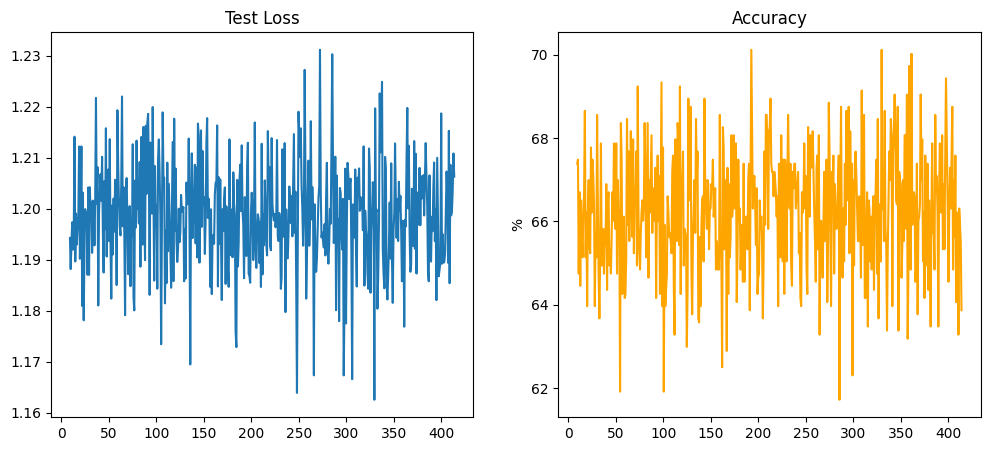

In [49]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Test Loss")
plt.plot(tth2, lth2)

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(tth2,[i * 100 for i in lath2], color="orange")
plt.ylabel("%")